# ぷれいちゅうでどれくらい取れているかを計測

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

sys.path.append('/home/mei/Documents/deep_sort/exp/20220609/utils')

from utils.frame import sec2frame
from utils.load_data import (load_annotated_trackret_file,
                             get_player_id_list,
                             load_pose_data,
                             load_bbox_data
                            )
from utils.matching import match_id_by_iou
from utils.frame import frame2sec
from IPython.core.debugger import Pdb
import multiprocessing
from multiprocessing import Manager, Process
from tqdm.notebook import tqdm
import pickle
import subprocess

In [2]:
ist = Pdb().set_trace

In [3]:
data_file_path = Path(os.getcwd())/'data'
data_name = data_file_path / 'p008_wtnb_0528.csv'
output_file_path: str = Path(os.getcwd())/'output'

In [4]:
df = pd.read_csv(data_name)
df.head()

,start,end,labels
0,77.761265,77.861253,OA
1,78.395459,78.470450,XB
2,78.978720,79.045378,XA
3,79.561053,79.602715,OB
4,91.541977,91.583639,OA


In [5]:
df['start_frame']=df['start'].apply(sec2frame)
df.head()

,start,end,labels,start_frame
0,77.761265,77.861253,OA,2330
1,78.395459,78.470450,XB,2349
2,78.978720,79.045378,XA,2366
3,79.561053,79.602715,OB,2384
4,91.541977,91.583639,OA,2743


<AxesSubplot:>

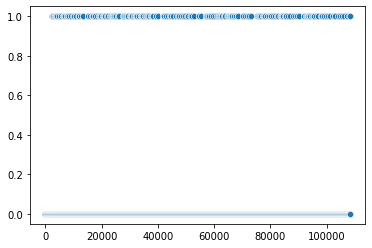

In [6]:
tmp = df.copy()
max_frame = df['start_frame'].max()+1
height = [1  if i in df['start_frame'].to_numpy() else 0 for i in range(max_frame)]
x = [i for i in range(max_frame)]

sns.scatterplot(x=x,y=height)

In [7]:
df.head(10)

,start,end,labels,start_frame
0,77.761265,77.861253,OA,2330
1,78.395459,78.470450,XB,2349
2,78.978720,79.045378,XA,2366
3,79.561053,79.602715,OB,2384
4,91.541977,91.583639,OA,2743
5,92.191896,92.250222,XB,2762
6,92.733496,92.800154,OA,2779
7,93.114926,93.164920,XB,2790
8,93.598199,93.656525,OA,2805
9,109.029614,109.071276,OB,3267


/home/mei/.pyenv/versions/3.6.8/envs/gmtracker/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


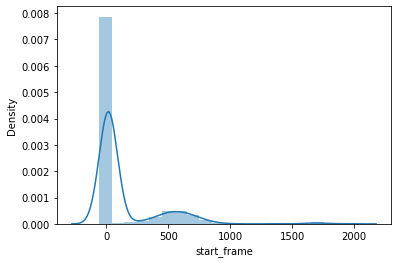

In [8]:
df_diff=df['start_frame'].diff()
sns.distplot(df_diff,bins=20)
plt.show()

In [9]:
def OtsuScore(data,thresh):
    """前後のプレーの時間差から閾値となる二値を決める"""
    w_0 = len(data[data > thresh])/len(data)
    w_1 = len(data[data <= thresh])/len(data)
    
    if w_0== 0 or w_1==0:
        return 0
    mean_all = data.mean()
    mean_0 = data[data>thresh].mean()
    mean_1 = data[data<=thresh].mean()
    
    sigma = w_0*((mean_0-mean_all)**2) + w_1*((mean_1-mean_all)**2)
    return sigma

iters = 20000
scores = [0] * iters
for i in range(iters):
    scores[i] = OtsuScore(df_diff,i)

print(max(scores))

60453.87752803594


330


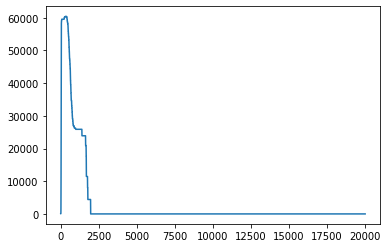

In [10]:
plt.plot(scores)
print(scores.index(max(scores)))

In [11]:
threshold = min(scores.index(max(scores)),100)
print(df_diff[df_diff>threshold].shape,df_diff[df_diff<=threshold].shape)

(154,) (593,)


In [12]:
cnt = 0
df = df.reset_index(drop=True)
df['df_diff'] = df_diff
df.loc[0,'group']=0
for i in range(1,len(df)):
    if df.loc[i,'df_diff']>=threshold:
        cnt += 1
    df.loc[i,'group'] = cnt
df.head()


,start,end,labels,start_frame,df_diff,group
0,77.761265,77.861253,OA,2330,NaN,0.0
1,78.395459,78.470450,XB,2349,19.0,0.0
2,78.978720,79.045378,XA,2366,17.0,0.0
3,79.561053,79.602715,OB,2384,18.0,0.0
4,91.541977,91.583639,OA,2743,359.0,1.0


In [13]:
df.groupby('group')['start_frame'].apply(lambda x: x.max()-x.min())

group
0.0      54
1.0      62
2.0      70
3.0      49
4.0      52
         ..
150.0    59
151.0    30
152.0    55
153.0    88
154.0    63
Name: start_frame, Length: 155, dtype: int64

## トラックレットを結合する

In [14]:
tracklet_name = data_file_path / 'p008_annotated_tracklet.csv'
tracklet = pd.read_csv(tracklet_name)
tracklet.head()

,frame,player1,player2
0,3.0,3,2
1,15.0,3,2
2,114.0,6,2
3,190.0,6,2
4,232.0,10,2


In [15]:
max_frame = 109275 +1 
all_df = pd.DataFrame({'frame':list(range(1,max_frame))})
all_df = pd.merge(all_df,tracklet,on='frame',how='left')
all_df = pd.merge(all_df,df[['start_frame','group','start','end']],left_on='frame',right_on='start_frame',how='left').drop(columns='start_frame')
# all_df['group'] = all_df['group'].fillna(method='ffill')
for c in ['player1','player2']:
    all_df[c] = all_df[c].replace({'-':-1})
    all_df[c] = all_df[c].astype(float)

## ラリー番号の保管方法を変える

In [16]:
# margin = 5

# group_dict = all_df.groupby('group').groups
# col_num = all_df.columns.get_loc('group')
# for group_id, frames in group_dict.items():
#     group_start_frame = frames.min()-margin
#     group_end_frame = frames.max()+50
#     all_df.iloc[group_start_frame:group_end_frame,col_num] = group_id

    

## トラックレットとkapaoidを組み合わせる

In [17]:
tracklet_df = load_annotated_trackret_file(tracklet_name)
player1_tracklet, player2_tracklet = get_player_id_list(tracklet_df)
video_name='p008'
pose_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/detection_poses_{video_name}.pkl"
pose_data=load_pose_data(pose_path)
bbox_path=bbox_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/{video_name}/{video_name}_deepsort_output.txt"
bbox_list: list= load_bbox_data(bbox_path)

In [18]:
tracklet_df
player1_tracklet
pose_data[0]
bbox_list[0]

[3, 1, 1674.26, 386.02, 243.47, 445.98, 1, -1, -1, -1]

In [19]:
# %%time
# def wrap(frame_id,d):
#     out_pose=match_id_by_iou(pose_data,bbox_list,frame_id)
#     player_id_list:list=[]
#     for one_out_pose in out_pose:
#         player_id = one_out_pose[1]
#         if player_id<0:
#             continue
#         player_id_list.append(player_id)
#     d[frame_id]=player_id_list


# # kapao と deepsortのidを対応付けしたものを保存

# processes = multiprocessing.cpu_count()
# progress_bar = tqdm(total=max_frame)
# d = Manager().dict()
# args = [(i,d) for i in range(1,max_frame)]
# with multiprocessing.Pool(processes=processes) as pool:
#     for _ in pool.starmap(wrap,args):
#         progress_bar.update(1)

# dict(d)
# d_ = dict(d)

# import pickle

# with open(str(data_file_path/'player_id_dict.pickle'),'wb') as f:
#     pickle.dump(d_,f)

In [20]:
# import pickle

# with open(str(data_file_path/'player_id_dict.pickle'),'wb') as f:
#     pickle.dump(d_,f)

# kapaoとdeepsortをidで紐づけたものをつかっていく

In [21]:
# with open(str(data_file_path/'player_id_dict.pickle'),'rb') as f:
#     kapao_deepsort_data = pickle.load(f)

# kapao_deepsort_data = list(sorted(kapao_deepsort_data.items(), key=lambda x: x[0]))

# kapao_deepsort_data_df = pd.DataFrame(kapao_deepsort_data,columns=['frame_id','player_ids'])

# kapao_deepsort_data_df.to_parquet(str(data_file_path/'deepsort_player_ids.parquet'))

deepsort_player_ids_df = pd.read_parquet(str(data_file_path/'deepsort_player_ids.parquet'))
deepsort_player_ids_df.head()

,frame_id,player_ids
0,1,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,2,"[0, 1, 2, 3, 4, 5]"
2,3,"[2, 1, 3, 4]"
3,4,"[2, 3, 1, 4]"
4,5,"[3, 2, 1]"


In [22]:
for c in ['player1','player2']:
    all_df[c+'_fill'] = all_df[c].fillna(method='ffill')

In [23]:
all_df.head()

,frame,player1,player2,group,start,end,player1_fill,player2_fill
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3.0,2.0,NaN,NaN,NaN,3.0,2.0
3,4,NaN,NaN,NaN,NaN,NaN,3.0,2.0
4,5,NaN,NaN,NaN,NaN,NaN,3.0,2.0


In [24]:
merged_df = pd.merge(all_df,deepsort_player_ids_df, left_on='frame', right_on='frame_id',how='left').drop(columns=['frame_id'])
merged_df

,frame,player1,player2,group,start,end,player1_fill,player2_fill,player_ids
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 2, 3, 4, 5]"
2,3,3.0,2.0,NaN,NaN,NaN,3.0,2.0,"[2, 1, 3, 4]"
3,4,NaN,NaN,NaN,NaN,NaN,3.0,2.0,"[2, 3, 1, 4]"
4,5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,"[3, 2, 1]"
...,...,...,...,...,...,...,...,...,...
109270,109271,NaN,NaN,NaN,NaN,NaN,-1.0,6495.0,[]
109271,109272,NaN,NaN,NaN,NaN,NaN,-1.0,6495.0,[]
109272,109273,NaN,NaN,NaN,NaN,NaN,-1.0,6495.0,[]
109273,109274,NaN,NaN,NaN,NaN,NaN,-1.0,6495.0,[]


In [25]:
def is_exist(df:pd.Series,column_name:str):
    """存在するかチェック"""
    return df[column_name+'_fill'] in (set(df['player_ids']))

In [26]:
%%time
_tmp_df = merged_df.copy()
progress_bar = tqdm(range(len(_tmp_df)),total=len(_tmp_df))
for i in progress_bar:
    row_df = _tmp_df.iloc[i,:]
    for c in ['player1','player2']:
        _tmp_df.loc[i,c+'_exist'] = 1 if is_exist(row_df,c) else 0
    
_tmp_df['player12_exist'] = (_tmp_df['player1_exist'] + _tmp_df['player2_exist']).apply(lambda x: 1 if x>=2 else 0)
_tmp_df['player_nexist'] = (_tmp_df['player1_exist'] + _tmp_df['player2_exist']).apply(lambda x: 1 if x<=0 else 0)



  0%|          | 0/109275 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 122 ms, total: 1min 29s
Wall time: 1min 29s


In [27]:
_tmp_df.groupby('group')['player12_exist'].agg(['sum','mean']).describe()

,sum,mean
count,155.000000,155.000000
mean,3.638710,0.767452
std,2.215306,0.241508
min,1.000000,0.200000
25%,2.000000,0.591667
50%,3.000000,0.800000
75%,5.000000,1.000000
max,11.000000,1.000000


In [28]:
groups_ids = _tmp_df.groupby('group').groups

In [29]:
player1_exist_list = []
player2_exist_list = []
player12_exist_list = []
player_nexist_list = []


for k,v in groups_ids.items():
    group_df = _tmp_df.iloc[v,:]
    group_df = group_df[['player1_exist','player2_exist','player12_exist','player_nexist']].mean()
    a = group_df.iloc[0]
    b = group_df.iloc[1]
    c = group_df.iloc[2]
    d = group_df.iloc[3]
    player1_exist_list.append(a)
    player2_exist_list.append(b)
    player12_exist_list.append(c)
    player_nexist_list.append(d)
    

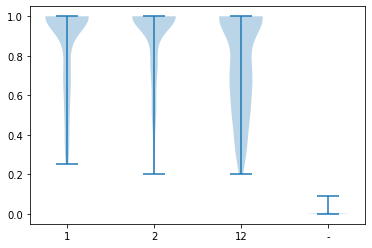

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.violinplot([player1_exist_list,player2_exist_list,player12_exist_list,player_nexist_list])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['1','2','12','-'])
plt.show()

In [31]:
_tt = [[a,b,c,d] for a,b,c,d in zip(player1_exist_list,player2_exist_list,player12_exist_list,player_nexist_list)]

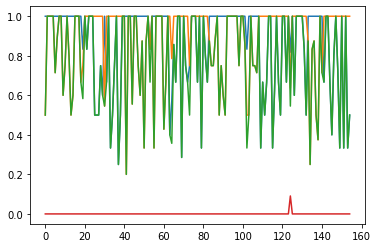

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(_tt)
plt.show()

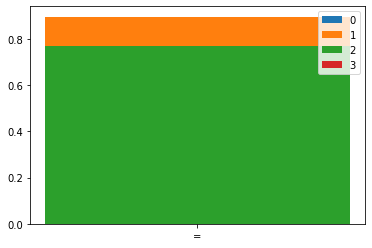

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i,a in enumerate([player1_exist_list,player2_exist_list,player12_exist_list,player_nexist_list]):
    ax.bar(height=sum(a)/len(a),x='=',label=i)
ax.legend()

# 適当に動画をサンプリングする

In [34]:
frame_df

NameError: name 'frame_df' is not defined

In [ ]:
frame_df

In [ ]:
frame_df['start'] = frame_df['frame'].apply(lambda x: frame2sec(x)/1000)
frame_df['end'] = frame_df['frame'].apply(lambda x: frame2sec(x)/1000)

In [39]:
_tmp_df['new_start'] = _tmp_df['frame'].apply(lambda x: frame2sec(x,fps=25))


In [40]:
idxs = _tmp_df[_tmp_df['group']==0].index
_tmp_df.iloc[idxs]

,frame,player1,player2,group,start,end,player1_fill,player2_fill,player_ids,player1_exist,player2_exist,player12_exist,player_nexist,new_start
2329,2330,NaN,NaN,0.0,77.761265,77.861253,125.0,122.0,"[125, 122, 60, 124]",1.0,1.0,1,0,93.20
2348,2349,NaN,NaN,0.0,78.395459,78.470450,125.0,122.0,"[122, 60, 124, 125]",1.0,1.0,1,0,93.96
2365,2366,NaN,NaN,0.0,78.978720,79.045378,125.0,122.0,"[60, 125, 124]",1.0,0.0,0,0,94.64
2383,2384,NaN,NaN,0.0,79.561053,79.602715,125.0,126.0,"[60, 124, 125]",1.0,0.0,0,0,95.36


In [41]:
input_file = str(output_file_path/'output.mp4')
def wrap(i):
    tar_ids = groups_ids[i]
    frame_df = _tmp_df.iloc[tar_ids,:]
    end_time:float = frame2sec(frame_df['frame'].max(),fps=25) + 5
    start_time:float = frame2sec(frame_df['frame'].min(),fps=25) - 5
    v_frames = sec2frame(end_time-start_time,fps=25)
    output_file = str(output_file_path/f'{i}.mp4')
    # if Path(output_file).exists():
    #     # print(f'{output_file} is exist')
    #     return 
    # command = command = f'ffmpeg -ss {start_frame} -i {input_file} -frames {v_frames} {output_file} -y'
    command = command = f'ffmpeg -y -ss {start_time} -i {input_file} -frames {v_frames}  {output_file}'

    print(start_time, end_time, v_frames)
    subprocess.call(command, shell=True)

In [42]:
processes = multiprocessing.cpu_count() 
progress = tqdm(range(len(groups_ids)))



with multiprocessing.Pool(processes=processes) as pool:
    for _ in pool.imap(wrap, range(len(groups_ids))):
        progress.update(1)

  0%|          | 0/155 [00:00<?, ?it/s]

88.2183.36104.72125.68 241.6164.4216.4 278.2100.36  145.48  259.72   333.64253.16197.44176.48303291.56231.84138.48 301.64117.2  
  271.72  157.44 301 351321.52319  385312
 
289300
299
334
 


 496
344.44 270

361.04 373.96 322
384.4 395.08 267
404.04 416.6 314
429.16 443.44 356
455.92 465.92 250
468.12 482.16 351496.68 
508.08 284
528.32 547.8 486
604.32 618.2 346
627.4 640.0 315
655.68 666.32 266
670.6 687.08 412
699.4 717.8 459
728.0 738.92 272
754.12 766.16 300
772.56 784.36 295
791.8 803.6 295
811.04 823.64 315
832.84 851.12 456865.0 876.72
 293
891.8 902.64 271
908.96 920.08 278
934.72 946.84 303
953.08 965.16 301
972.12 984.36 306
992.56 1004.64 302
1023.1199999999999 1033.96 271
1033.32 1047.2 347
1092.6 1103.32 268
1106.52 1119.16 316
1134.68 1146.56 296
1156.24 1166.24 250
1168.0 1182.76 368
1194.88 1204.88 250
1205.28 1218.08 319
1229.24 1242.04 319
1254.68 1267.68 325
1276.76 1290.64 347
1299.76 1311.04 281
1324.08 1338.0 348
1350.28 1362.32 300
1371.72 1388.76 425
1408.88 1

In [ ]:
# input_file = str(output_file_path/'output.mp4')
# progress = tqdm(range(len(groups_ids)))
# for i in progress:
#     tar_ids = groups_ids[i]
#     frame_df = _tmp_df.iloc[tar_ids,:]['frame']
#     end_frame = int(frame2sec(frame_df.max()))//1000
#     start_frame = int(frame2sec(frame_df.min()))//1000
#     v_frames = abs(end_frame-start_frame)
#     output_file = str(output_file_path/f'{i}.mp4')
#     command = command = f'ffmpeg -i {input_file} -ss {start_frame} -to {end_frame} {output_file} -y'
#     subprocess.call(command, shell=True)
    
    